# Car auto insurance

In [1]:
# Python libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, precision_score, recall_score, accuracy_score, f1_score

## 1) Reading and general analysis on the dataset

In [2]:
# Training dataset
train_data = pd.read_csv('data/auto-insurance-fall-2017/train_auto.csv', index_col=0)
# Test dataset
test_data = pd.read_csv('data/auto-insurance-fall-2017/test_auto.csv', index_col=0)

In [3]:
print('Shape of the training dataset: {}'.format(train_data.shape))
print('Shape of the test dataset: {}'.format(test_data.shape))

Shape of the training dataset: (8161, 25)
Shape of the test dataset: (2141, 25)


+ TARGET_FLAG is the variable to predict $Y$
+ TARGET_AMT isn't used
+ the over columns represent the covariates $X$

In [4]:
train_data.head(10)

,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,...,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
INDEX,,,,,,,,,,,,,,,,,,,,,
1,0,0.0,0,60.0,0,11.0,"$67,349",No,$0,z_No,...,"$14,230",11,Minivan,yes,"$4,461",2,No,3,18.0,Highly Urban/ Urban
2,0,0.0,0,43.0,0,11.0,"$91,449",No,"$257,252",z_No,...,"$14,940",1,Minivan,yes,$0,0,No,0,1.0,Highly Urban/ Urban
4,0,0.0,0,35.0,1,10.0,"$16,039",No,"$124,191",Yes,...,"$4,010",4,z_SUV,no,"$38,690",2,No,3,10.0,Highly Urban/ Urban
5,0,0.0,0,51.0,0,14.0,NaN,No,"$306,251",Yes,...,"$15,440",7,Minivan,yes,$0,0,No,0,6.0,Highly Urban/ Urban
6,0,0.0,0,50.0,0,NaN,"$114,986",No,"$243,925",Yes,...,"$18,000",1,z_SUV,no,"$19,217",2,Yes,3,17.0,Highly Urban/ Urban
7,1,2946.0,0,34.0,1,12.0,"$125,301",Yes,$0,z_No,...,"$17,430",1,Sports Car,no,$0,0,No,0,7.0,Highly Urban/ Urban
8,0,0.0,0,54.0,0,NaN,"$18,755",No,NaN,Yes,...,"$8,780",1,z_SUV,no,$0,0,No,0,1.0,Highly Urban/ Urban
11,1,4021.0,1,37.0,2,NaN,"$107,961",No,"$333,680",Yes,...,"$16,970",1,Van,yes,"$2,374",1,Yes,10,7.0,Highly Urban/ Urban
12,1,2501.0,0,34.0,0,10.0,"$62,978",No,$0,z_No,...,"$11,200",1,z_SUV,no,$0,0,No,0,1.0,Highly Urban/ Urban


The target variable is binary, it is thus a **classification task**.

In [5]:
print('Proportion of positive instances in the training set: {}'.format(round(train_data.TARGET_FLAG.mean(),2)))

Proportion of positive instances in the training set: 0.26


$\rightarrow$ the dataset is slightly imbalanced. We will be careful choosing the performance metrics.

## 2) Numerical features

### Converting currency features to float
Some numerical features represent prices and are thus encoded as string. We need to convert them to float.

In [6]:
def currency_to_float(x):
    if isinstance(x, str):
        return(x.replace('$', '').replace(',', ''))
    return(x)

In [7]:
currency_features = ['INCOME', 'HOME_VAL', 'BLUEBOOK', 'OLDCLAIM']
for feature in currency_features:
    train_data[feature] = train_data[feature].apply(currency_to_float).astype(float)
    test_data[feature] = test_data[feature].apply(currency_to_float).astype(float)

### Analysis of numerical features

We represent histograms of numerical features for each sub-population:
+ instances for which the target value is positive ($Y=1$, red)
+ instances for which the target value is negative ($Y=0$, blue)

In [8]:
numerical_features = list(train_data.describe(include=np.number).columns)
numerical_features.remove('TARGET_FLAG')
numerical_features.remove('TARGET_AMT') # we don't want to use that information !

In [9]:
# Function to represent histograms of variables given the target label
def hist(feature, ax):
    ax.hist(train_data[train_data.TARGET_FLAG==1][feature], color='red', label='$Y=1$', density=True, alpha=0.5)
    ax.hist(train_data[train_data.TARGET_FLAG==0][feature], color='blue', label='$Y=0$', density=True, alpha=0.5)
    ax.set_title(feature, fontsize=20)
    ax.legend(fontsize=15)

In [10]:
print(numerical_features)

['KIDSDRIV', 'AGE', 'HOMEKIDS', 'YOJ', 'INCOME', 'HOME_VAL', 'TRAVTIME', 'BLUEBOOK', 'TIF', 'OLDCLAIM', 'CLM_FREQ', 'MVR_PTS', 'CAR_AGE']


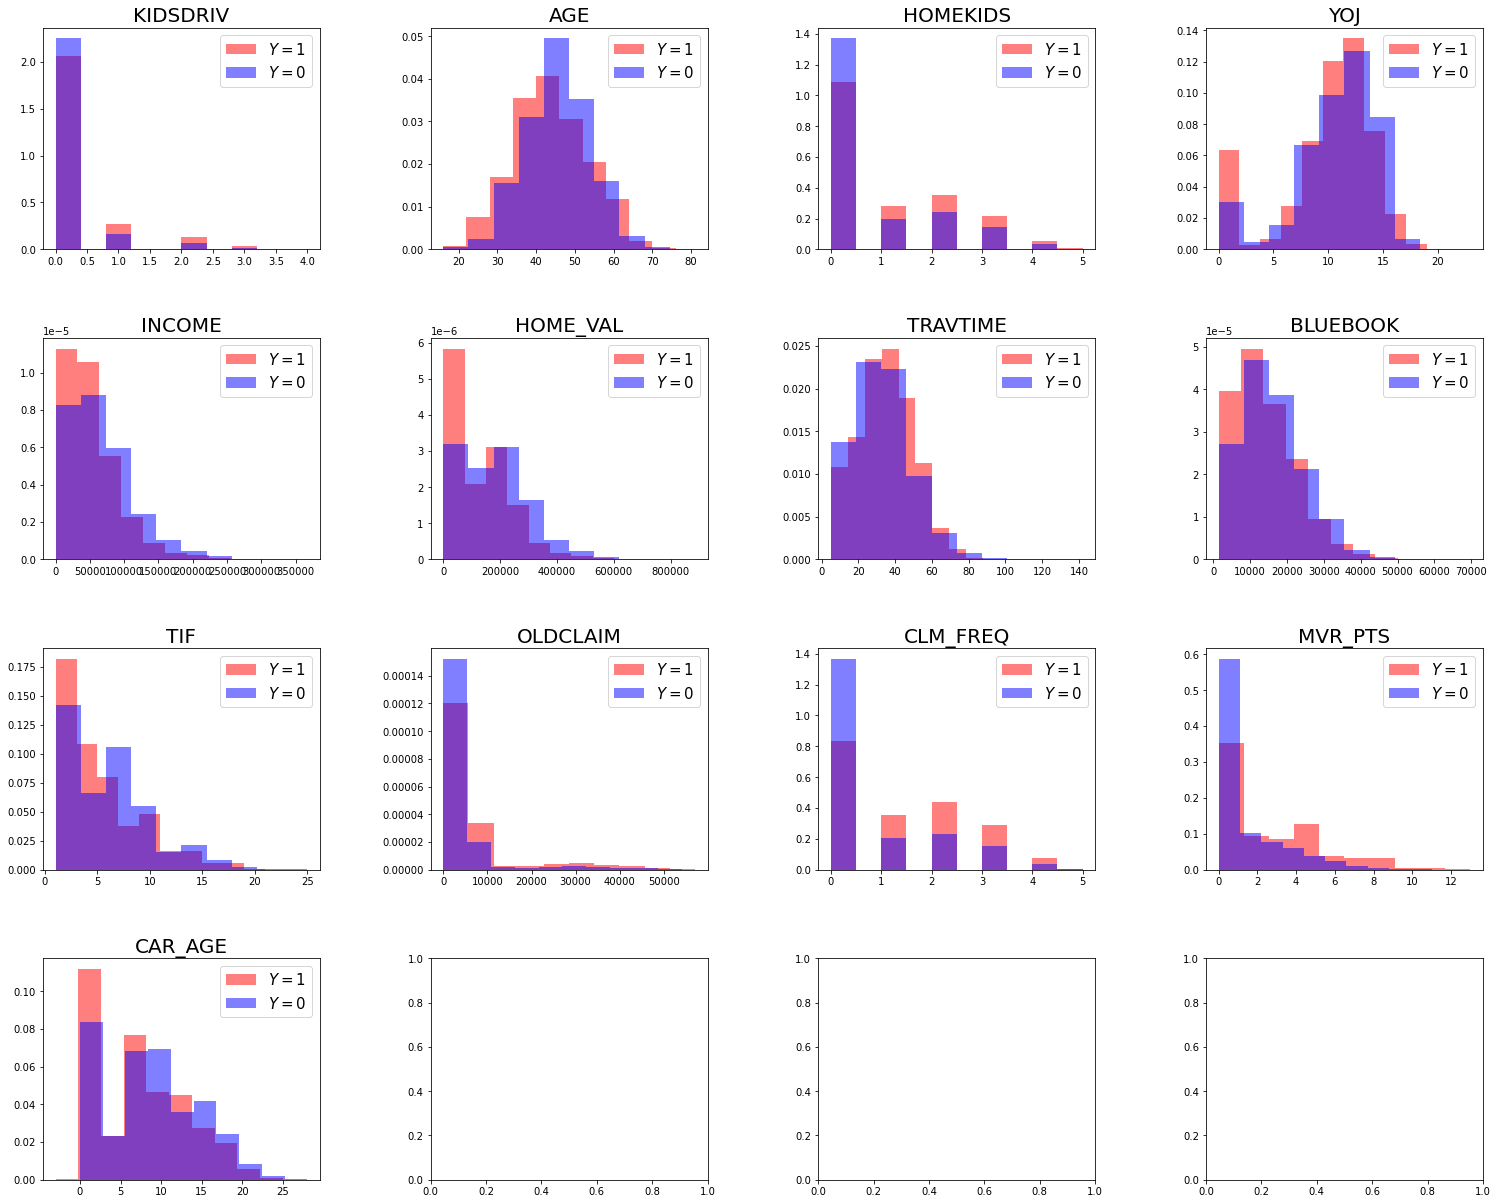

In [11]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(25,20))
hist('KIDSDRIV', axes[0,0])
hist('AGE', axes[0,1])
hist('HOMEKIDS', axes[0,2])
hist('YOJ', axes[0,3])
hist('INCOME', axes[1,0])
hist('HOME_VAL', axes[1,1])
hist('TRAVTIME', axes[1,2])
hist('BLUEBOOK', axes[1,3])
hist('TIF', axes[2,0])
hist('OLDCLAIM', axes[2,1])
hist('CLM_FREQ', axes[2,2])
hist('MVR_PTS', axes[2,3])
hist('CAR_AGE', axes[3,0])
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
plt.show()

This already gives a few insights about which feature might be relevant to predict the target $Y$:
+ lower income (INCOME) and home values (HOME_VAL result in a higher probability of having $Y=1$
+ variables OLDCLAIM, CLM_FREQ and MVR_PTS seems to be correlated to the target $Y$.

## 3) Dealing with categorical features

### General analysis of numerical features

Similarly to numerical features, we can represent the empirical distributions of categorical variables for each sub-population.

In [12]:
cat_features = train_data.describe(include='object').columns

In [13]:
cat_features

Index(['PARENT1', 'MSTATUS', 'SEX', 'EDUCATION', 'JOB', 'CAR_USE', 'CAR_TYPE',
       'RED_CAR', 'REVOKED', 'URBANICITY'],
      dtype='object')

In [14]:
def hist_cat(feature, ax):
    ax.hist([train_data[train_data.TARGET_FLAG==1][feature].astype(str), train_data[train_data.TARGET_FLAG==0][feature].astype(str)], color=['red', 'blue'], label=['$Y=1$', '$Y=0$'])
    ax.tick_params(axis='x', rotation=45, labelsize=15)
    ax.set_ylabel('Count', fontsize=15)
    ax.set_title(feature, fontsize=20)
    ax.legend(fontsize=15)

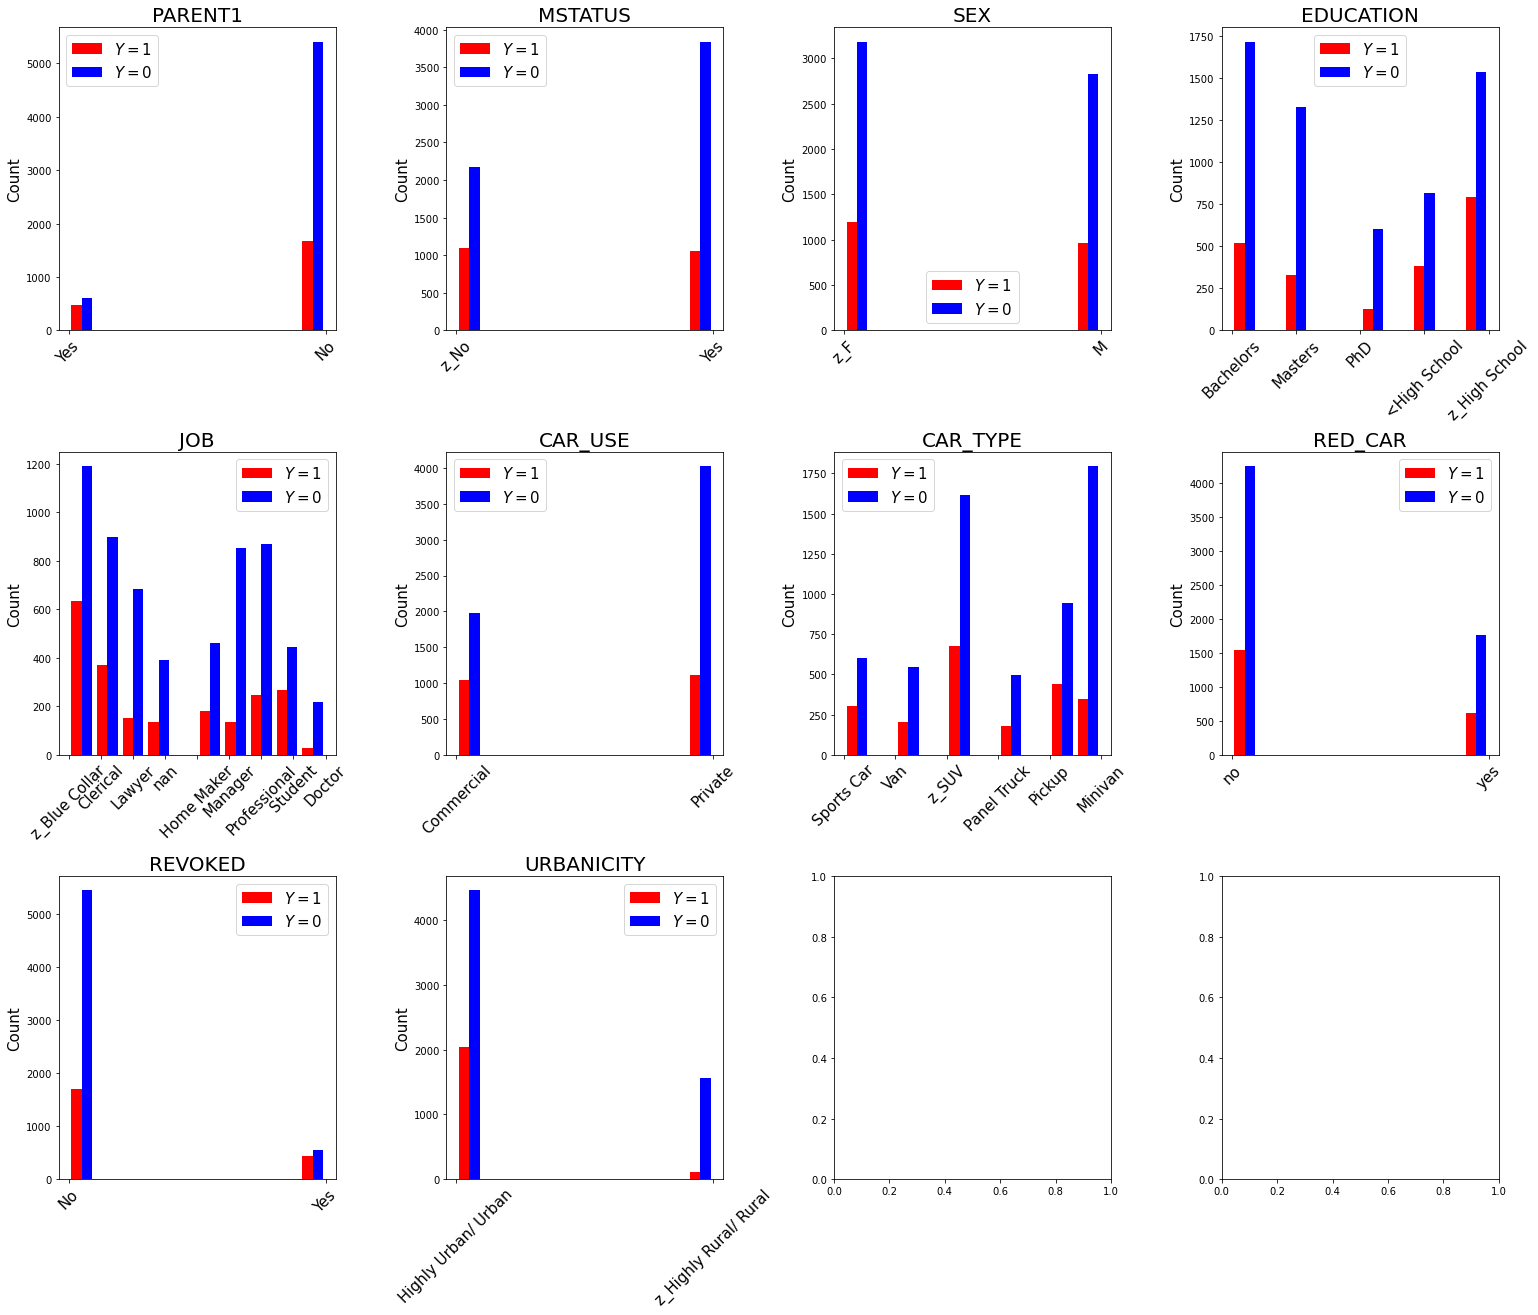

In [15]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(25,20))
hist_cat('PARENT1', axes[0,0])
hist_cat('MSTATUS', axes[0,1])
hist_cat('SEX', axes[0,2])
hist_cat('EDUCATION', axes[0,3])
hist_cat('JOB', axes[1,0])
hist_cat('CAR_USE', axes[1,1])
hist_cat('CAR_TYPE', axes[1,2])
hist_cat('RED_CAR', axes[1,3])
hist_cat('REVOKED', axes[2,0])
hist_cat('URBANICITY', axes[2,1])
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
plt.show()

Again, this gives useful insights about features relevant in the prediction of the output target $Y$.

### Encoding categorical features

We need to encode categorical variables as numerical values before training machine learning algorithms.
The simplest choice in this case is to resort to One Hot Encoding. This means that every categorical features is transformed into $d-1$ binary variables where $d$ is the number of categories.
Note that we could encode the variable EDUCATION in a more efficient way using the hierarchy between the levels of studies. (I did not do it here to keep it simpler)

In [16]:
encoder = OneHotEncoder(sparse=False, drop='first')

In [17]:
train_cat_encoded = encoder.fit_transform(train_data[cat_features])
test_cat_encoded = encoder.transform(test_data[cat_features])

In [18]:
print(train_cat_encoded.shape)
print(test_cat_encoded.shape)

(8161, 24)
(2141, 24)


We now have transformed our categorical feartures into numerical values. However, one hot encoding results in an increase of the dimension (from $10$ to $24$).

In [19]:
new_cat_features = encoder.get_feature_names(cat_features)

C:\Users\u607316\AppData\Local\conda\conda\envs\these\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [20]:
new_cat_features

array(['PARENT1_Yes', 'MSTATUS_z_No', 'SEX_z_F', 'EDUCATION_Bachelors',
       'EDUCATION_Masters', 'EDUCATION_PhD', 'EDUCATION_z_High School',
       'JOB_Doctor', 'JOB_Home Maker', 'JOB_Lawyer', 'JOB_Manager',
       'JOB_Professional', 'JOB_Student', 'JOB_z_Blue Collar', 'JOB_nan',
       'CAR_USE_Private', 'CAR_TYPE_Panel Truck', 'CAR_TYPE_Pickup',
       'CAR_TYPE_Sports Car', 'CAR_TYPE_Van', 'CAR_TYPE_z_SUV',
       'RED_CAR_yes', 'REVOKED_Yes', 'URBANICITY_z_Highly Rural/ Rural'],
      dtype=object)

## 4) Concatenate encoded categorical features and numerical features

In [21]:
Y = train_data.TARGET_FLAG   # target variable (binary)

In [22]:
X = np.concatenate([train_data[numerical_features].values, train_cat_encoded], axis=1)
X_test = np.concatenate([test_data[numerical_features].values, test_cat_encoded], axis=1)

In [23]:
features = list(numerical_features) + list(new_cat_features) # list of features
print(features)

['KIDSDRIV', 'AGE', 'HOMEKIDS', 'YOJ', 'INCOME', 'HOME_VAL', 'TRAVTIME', 'BLUEBOOK', 'TIF', 'OLDCLAIM', 'CLM_FREQ', 'MVR_PTS', 'CAR_AGE', 'PARENT1_Yes', 'MSTATUS_z_No', 'SEX_z_F', 'EDUCATION_Bachelors', 'EDUCATION_Masters', 'EDUCATION_PhD', 'EDUCATION_z_High School', 'JOB_Doctor', 'JOB_Home Maker', 'JOB_Lawyer', 'JOB_Manager', 'JOB_Professional', 'JOB_Student', 'JOB_z_Blue Collar', 'JOB_nan', 'CAR_USE_Private', 'CAR_TYPE_Panel Truck', 'CAR_TYPE_Pickup', 'CAR_TYPE_Sports Car', 'CAR_TYPE_Van', 'CAR_TYPE_z_SUV', 'RED_CAR_yes', 'REVOKED_Yes', 'URBANICITY_z_Highly Rural/ Rural']


In [24]:
X.shape

(8161, 37)

## 5) Prepare data for training
+ Fill missing values (Nan): we impute missing values using a KNN (nearest neighbors) model
+ Normalize data
+ train / validation split: we will train our models using the train set and compare their performances over the validation set

In [25]:
# Imput missing values
imputer = KNNImputer()
X = imputer.fit_transform(X)
X_test = imputer.transform(X_test)

In [26]:
# Normalize features
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)
X_test = scaler.fit_transform(X_test)

In [27]:
# Train validation split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.33, random_state=1)

## Training

The target variable $Y$ is binary ($0$ or $1$). Hence, this is a classification task. The objective is to use the training set $(X_{train}, Y_{train})$ to estimate a classifier that will give good predictions on the test set.

We use the validation set to assess the performances of each method.

### Linear Logistic Regression

In [28]:
model_lr = LogisticRegression()

In [29]:
model_lr.fit(X_train, Y_train)

LogisticRegression()

In [30]:
y_pred_lr = model_lr.predict_proba(X_val)[:,1]

In [31]:
accuracy_score(Y_val, y_pred_lr>=0.5)

0.7910170749814402

The accuracy score is not a good metric here. A naive classifier always predicting $0$ would have an accuracy close to $0.74$...
Better metrics are:
+ precision and recall
+ f1 score (compromise between precision and recall)
+ ROC AUC: does not require the specification of the decision threshold

In [32]:
scores_lr = {'Recall':recall_score(Y_val, y_pred_lr>=0.5), 'Precision':precision_score(Y_val, y_pred_lr>=0.5), 'F1':f1_score(Y_val, y_pred_lr>=0.5), 'ROC_AUC':roc_auc_score(Y_val, y_pred_lr)}

### Linear Discriminant Analysis

In [33]:
model_lda = LinearDiscriminantAnalysis()
model_lda.fit(X_train, Y_train)

LinearDiscriminantAnalysis()

In [34]:
y_pred_lda = model_lda.predict_proba(X_val)[:,1]

In [35]:
scores_lda = {'Recall':recall_score(Y_val, y_pred_lda>=0.5), 'Precision':precision_score(Y_val, y_pred_lda>=0.5), 'F1':f1_score(Y_val, y_pred_lda>=0.5), 'ROC_AUC':roc_auc_score(Y_val, y_pred_lda)}

### Support Vector Machine with Gaussian kernel (SVM)
I did not optimize the hyperparameter $C$. This could be done for instance using cross validation to select the best value.

In [36]:
model_svm = SVC(C=1.)  
model_svm.fit(X_train, Y_train)

SVC()

In [37]:
y_pred_svm = model_svm.decision_function(X_val)

In [38]:
scores_svm = {'Recall':recall_score(Y_val, y_pred_svm>=0.), 'Precision':precision_score(Y_val, y_pred_svm>=0.), 'F1':f1_score(Y_val, y_pred_svm>=0.), 'ROC_AUC':roc_auc_score(Y_val, y_pred_svm)}

### Random forest
Again, some hyperparameters like the maximum depth of trees could be optimized.

In [39]:
model_rf = RandomForestClassifier(max_depth=10, max_features='sqrt')
model_rf.fit(X_train, Y_train)
y_pred_rf = model_rf.predict_proba(X_val)[:,1]

In [40]:
scores_rf = {'Recall':recall_score(Y_val, y_pred_rf>=0.5), 'Precision':precision_score(Y_val, y_pred_rf>=0.5), 'F1':f1_score(Y_val, y_pred_rf>=0.5), 'ROC_AUC':roc_auc_score(Y_val, y_pred_rf)}

## Performance comparison

In [41]:
performances = pd.DataFrame([scores_lr, scores_lda, scores_svm, scores_rf], index=['Logistic Regression', 'Linear Discriminant Analysis', 'SVM', 'Random Forest'])

In [42]:
performances.round(3)

,Recall,Precision,F1,ROC_AUC
Logistic Regression,0.450,0.650,0.532,0.806
Linear Discriminant Analysis,0.442,0.650,0.526,0.802
SVM,0.405,0.652,0.500,0.797
Random Forest,0.286,0.684,0.403,0.802


Performances are similar for the different methods. It seems that the linear models (Logistic Regression and Linear Discriminant Analysis) perform slightly better (maybe because the others were not fully optimized). In order to confirm that, we would need to repeat the procedure with random partitions between train and validation sets in order to assess the variability on the performance evaluation.

From these $4$ classifiers, it seems reasonable to choose the Logistic Regression which provides the best F1 score and area under ROC curve. Besides it is a simpler model than the others and it is easy to interprete.

## Final submission

We now train the chosen model on the whole training dataset and generate the csv file with the predictions on the test set.

In [43]:
final_model = LogisticRegression()
final_model.fit(X, Y)

LogisticRegression()

We compute the predictions given by the trained model on the test set.

In [44]:
predictions = final_model.predict(X_test)

We store the predictions in the column TARGET_FLAG of the test dataframe and save it as the submission.

In [45]:
test_data = pd.read_csv('data/auto-insurance-fall-2017/test_auto.csv', index_col=0)
test_data['TARGET_FLAG'] = predictions
test_data.to_csv('predictions.csv')